In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
from design import Design
from film import FilmSimple
from spectrum import Spectrum
from optimizer.LM_gradient_descent import LM_optimize_d_simple
from optimizer.adam import adam_optimize
import copy
import pickle


inc_ang = 0.
wls = np.linspace(400, 1000, 500) # when wls = 50, ~100 min
target_spec = Spectrum(inc_ang, wls, np.ones(wls.shape[0], dtype='float'))



def is_saddle(design: Design, h=1e-5):
    # TODO: change diag elem to eigenvalues of Hessian (estimiate with finite difference)
    # semi-positive definite -> diag(H) >= 0
    # diag(H) < 0 -> not semi-positive definite -> not saddle
    f = design.film
    loss_0 = design.calculate_loss()
    loss_pos = []
    loss_neg = []
    for i in range(f.get_layer_number()):
        d = f.get_d()
        d[i] += h
        f.update_d(d)
        loss_pos.append(design.calculate_loss())
        
        d[i] -= 2 * h
        f.update_d(d)
        loss_neg.append(design.calculate_loss())

        d[i] += h
        f.update_d(d)
        
    
    return np.array([loss_0] * len(loss_neg)), np.array(loss_neg), np.array(loss_pos)

In [101]:
def exp_LM(layers, max_step):
    total_gt = 5000
    init_film = FilmSimple('SiO2', 'TiO2', 'SiO2', np.random.random(layers) * total_gt / layers)
    design = Design([target_spec], init_film)

    step = LM_optimize_d_simple(design.film, [target_spec], h_tol=1e-200, max_step=max_step, show=False)
    print(f'{layers} layers {step} steps')
    h  = 1e-3
    loss_0, loss_neg, loss_pos = is_saddle(design, h=h)

    return [step] * len(loss_neg), (loss_0 - loss_pos) / (loss_0 - loss_neg),
    

xy_ls = []

max_steps = [500, 1000, 3000, 5000]
N = 5
layers_ls = [20] * N + [50] * N + [100] * N
for i, layers in enumerate(layers_ls):
    
    for j, max_step in enumerate(max_steps):
        np.random.seed(i)
        x, y = exp_LM(layers, max_step)
        xy_ls.append((x, y))



20 layers 499 steps
20 layers 514 steps
20 layers 514 steps
20 layers 514 steps
20 layers 386 steps
20 layers 386 steps
20 layers 386 steps
20 layers 386 steps
20 layers 469 steps
20 layers 469 steps
20 layers 469 steps
20 layers 469 steps
20 layers 334 steps
20 layers 334 steps
20 layers 334 steps
20 layers 334 steps
20 layers 384 steps
20 layers 384 steps
20 layers 384 steps
20 layers 384 steps
50 layers 499 steps
50 layers 504 steps
50 layers 504 steps
50 layers 504 steps
50 layers 499 steps
50 layers 999 steps
50 layers 2999 steps
50 layers 3823 steps
50 layers 499 steps
50 layers 666 steps
50 layers 666 steps
50 layers 666 steps
50 layers 499 steps
50 layers 999 steps
50 layers 2999 steps
50 layers 4999 steps
50 layers 499 steps
50 layers 999 steps
50 layers 2999 steps
50 layers 3673 steps
100 layers 499 steps
100 layers 999 steps
100 layers 2999 steps
100 layers 4999 steps
100 layers 499 steps
100 layers 999 steps
100 layers 1018 steps
100 layers 1018 steps
100 layers 499 steps
1

(-2.0, 2.0)

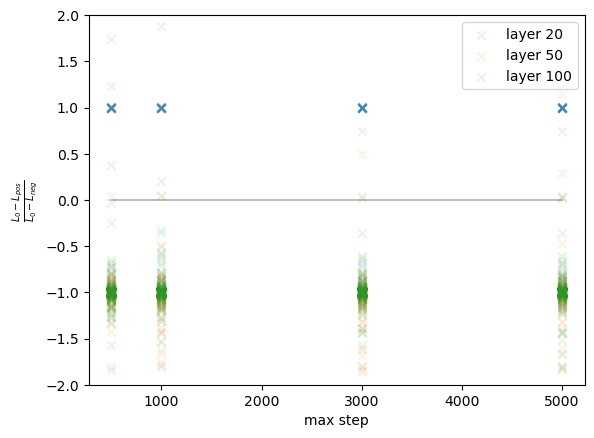

In [105]:
fig, ax = plt.subplots(1, 1)
xy_gen = iter(xy_ls)


for i, layers in enumerate(layers_ls):
    for j, max_step in enumerate(max_steps):
        x, y = next(xy_gen)
        ax.scatter(
            x, 
            y, 
            label=f'layer {layers}' if j == 0 and i % N == 0 else None,
            c = f'C{i // N}',
            marker='x', 
            alpha=0.1
        )
ax.plot([max_steps[0], max_steps[-1]], [0, 0], alpha=0.5, color='grey')
ax.set_xlabel('max step')
ax.set_ylabel('$\\frac{L_{0} - L_{pos}}{L_{0} - L_{neg}}$')
ax.legend()
ax.set_ylim(-2, 2)

In [3]:
# debug & exp with adam
def exp_adam(layers, max_step):
    total_gt = 5000
    init_film = FilmSimple('SiO2', 'TiO2', 'SiO2', np.random.random(layers) * total_gt / layers)
    design = Design([target_spec], init_film)

    losses = adam_optimize(design.film, [target_spec], max_step, alpha=1, record=True)
    print(f'{layers} layers {max_step} steps')
    h  = 1e-3
    loss_0, loss_neg, loss_pos = is_saddle(design, h=h)

    return [max_step] * len(loss_neg), (loss_0 - loss_pos) / (loss_0 - loss_neg),
    
xy_ls = []

max_steps = [500, 1000, 3000, 5000]
N = 5
layers_ls = [20] * N + [50] * N + [100] * N
for i, layers in enumerate(layers_ls):
    
    for j, max_step in enumerate(max_steps):
        np.random.seed(i)
        x, y = exp_adam(layers, max_step)
        xy_ls.append((x, y))


20 layers [0.4752978239923808, 0.45235593048954126, 0.4329057083394997, 0.42698395228961317, 0.4260372276900629, 0.4229877035047718, 0.4169999096425221, 0.4079616511867978, 0.39699265069863143, 0.38755226606419285, 0.38147175091696817, 0.3766970616317246, 0.37060537693705936, 0.3624839037465996, 0.3537514329016561, 0.34614153812371506, 0.3396990822110471, 0.33376802691930596, 0.328743915676263, 0.3252154619671532, 0.3226585217522237, 0.319916305939203, 0.3161298789872912, 0.3114316731307047, 0.30642171048262623, 0.30185136074558544, 0.2980568510177017, 0.29483123653354093, 0.29158899742875555, 0.287976881497747, 0.28416458282075635, 0.28058217210198483, 0.2775025128783249, 0.27566324233808154, 0.27421937934984797, 0.2727493822840505, 0.2710771583344783, 0.26915200558084057, 0.2667942022178894, 0.2643412532703858, 0.26250285246371746, 0.2607158853831607, 0.2591712609005996, 0.2580674877793689, 0.2571084647922709, 0.25605811041210014, 0.2548098766790425, 0.25342213849355083, 0.2521034561

(-2.0, 2.0)

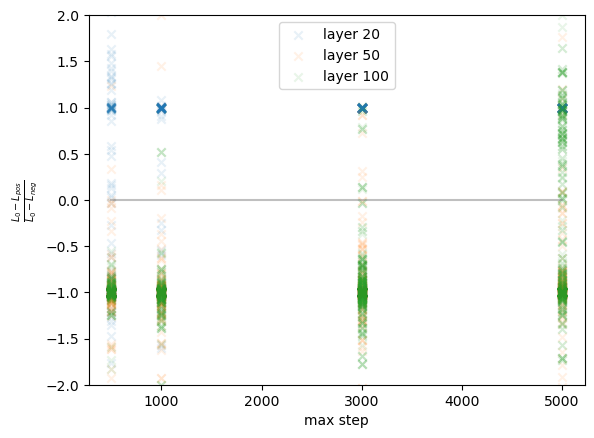

In [4]:
fig, ax = plt.subplots(1, 1)
xy_gen = iter(xy_ls)


for i, layers in enumerate(layers_ls):
    for j, max_step in enumerate(max_steps):
        x, y = next(xy_gen)
        ax.scatter(
            x, 
            y, 
            label=f'layer {layers}' if j == 0 and i % N == 0 else None,
            c = f'C{i // N}',
            marker='x', 
            alpha=0.1
        )
ax.plot([max_steps[0], max_steps[-1]], [0, 0], alpha=0.5, color='grey')
ax.set_xlabel('max step')
ax.set_ylabel('$\\frac{L_{0} - L_{pos}}{L_{0} - L_{neg}}$')
ax.legend()
ax.set_ylim(-2, 2)

In [50]:
def convergence(layers, max_step):
    # make design for adam
    total_gt = 5000
    np.random.seed(4)
    init_film = FilmSimple('SiO2', 'TiO2', 'SiO2', np.random.random(layers) * total_gt / layers)
    design_adam = Design([target_spec], init_film)

    losses_adam = adam_optimize(design_adam.film, [target_spec], max_step, alpha=1, record=True)
    
    design_LM = Design([target_spec], copy.deepcopy(design_adam.init_film))
    steps, losses_LM = LM_optimize_d_simple(design_LM.film, [target_spec], h_tol=1e-200, max_step=max_step, show=False, record=True)


    return losses_adam, losses_LM, design_adam, design_LM

losses_adam, losses_LM, design_adam, design_LM = convergence(100, 5000)

# TODO: see what happens at the sdden increase of loss... seed = 1, layer = 100, @ epoch ~ 3600


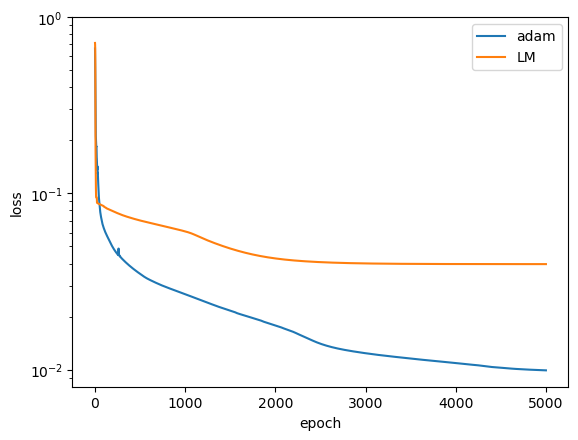

In [51]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(losses_adam)), losses_adam, label='adam')
ax.plot(np.arange(len(losses_LM)), losses_LM, label='LM')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.set_ylim(None, 1.)
ax.legend()

In [52]:
from utils.substitutue import equal_optical_thickness, optimal_and_thin_film_approx_substitution_onestep_new, search_ot_substitution

# substitute the previous films
loss_eq_ot = []
loss_optim = []
loss_search = []
d_mins = np.linspace(0, 30, 100)
for d_min in d_mins:    
    # although the approximation in optim sub only applies to thin d_min, the *likelihood* for it to *outperform* eq ot is larger at large d_min
    design_adam.film.add_spec_param(target_spec.INC_ANG, target_spec.WLS)

    f_origin = copy.deepcopy(design_adam.film)

    equal_optical_thickness(design_adam.film, d_min)
    loss_eq_ot.append(design_adam.calculate_loss())
    print(design_adam.calculate_loss())
    design_adam.film = copy.deepcopy(f_origin)

    optimal_and_thin_film_approx_substitution_onestep_new(design_adam.film, d_min)
    loss_optim.append(design_adam.calculate_loss())
    print(design_adam.calculate_loss())
    design_adam.film = copy.deepcopy(f_origin)

    search_ot_substitution(design_adam.film, d_min)
    loss_search.append(design_adam.calculate_loss())
    print(design_adam.calculate_loss())
    design_adam.film = copy.deepcopy(f_origin)
    

0.009913980144706298
0.009913980144706298
0.009913980144706298
0.009913980144706297
0.009913980144706297
0.009913980144706297
0.009913980144706297
0.009913980144706297
0.009913980144706297
0.009913980144706297
0.009913980144706297
0.009913980144706297
0.010144098783725838
0.010070675698891595
0.010184347938581459
0.010144098783725838
0.010070675698891595
0.010184347938581459
0.010144098783725838
0.010070675698891595
0.010184347938581459
0.010144098783725838
0.010070675698891595
0.010184347938581459
0.010144098783725838
0.010070675698891595
0.010184347938581459
0.010144098783725838
0.010070675698891595
0.010184347938581459
0.010144098783725838
0.010070675698891595
0.010184347938581459
0.010144098783725838
0.010070675698891595
0.010184347938581459
0.010144098783725838
0.010070675698891595
0.010184347938581459
0.010144098783725838
0.010070675698891595
0.010184347938581459
0.010144098783725838
0.010070675698891595
0.010184347938581459
0.010144098783725838
0.010070675698891595
0.01018434793